In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda")

In [4]:
class BayesianCNNSingleFC(PyroModule):
    def __init__(self, num_classes):
        super().__init__()

        prior_mu = 0.
        #prior_sigma = 0.1 #accuracy 13.203704% 2 epochs
        #prior_sigma = 1. #accuracy 31% 2 epochs
        prior_sigma = torch.tensor(10., device=device) #accuracy 45% 10 epochs
        #prior_sigma = 100 #accuracy 21% 10 epochs

        self.conv1 = PyroModule[nn.Conv2d](3, 32, kernel_size=5, stride=1, padding=2)
        self.conv1.weight = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([32, 3, 5, 5]).to_event(4))
        self.conv1.bias = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([32]).to_event(1))

        self.conv2 = PyroModule[nn.Conv2d](32, 64, kernel_size=5, stride=1, padding=2) #initially padding=1 kernel_size=3, without stride
        self.conv2.weight = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([64, 32, 5, 5]).to_event(4))
        self.conv2.bias = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([64]).to_event(1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = PyroModule[nn.Linear](64 * 16 * 16, num_classes)
        self.fc1.weight = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([num_classes, 64 * 16 * 16]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(prior_mu, prior_sigma).expand([num_classes]).to_event(1))

    def forward(self, x, y=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        logits = self.fc1(x)
        
        # THIS IS THE MISSING PIECE: Define the likelihood
        if y is not None:
            with pyro.plate("data", x.shape[0]):
                pyro.sample("obs", dist.Categorical(logits=logits), obs=y)
        
        return logits

In [5]:
def old_load_data(batch_size=54): 
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    # Use fixed random seed for reproducible splits
    torch.manual_seed(42)
    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader

In [6]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [7]:
num_classes = 10
bayesian_model = BayesianCNNSingleFC(num_classes=num_classes).to(device)

In [8]:
import pyro
import pyro.distributions as dist
import pyro.nn
import torch
import torch.nn as nn
from pyro.nn import PyroModule, PyroParam
from torch.distributions import constraints

class CustomGuide(PyroModule):
    def __init__(self, num_classes):
        super().__init__()

        # conv1 weights and bias
        self.conv1_weight_loc = PyroParam(torch.randn(32, 3, 5, 5) * 0.1)
        self.conv1_weight_scale = PyroParam(torch.ones(32, 3, 5, 5) * 0.1, constraint=constraints.positive)
        self.conv1_bias_loc = PyroParam(torch.randn(32) * 0.1)
        self.conv1_bias_scale = PyroParam(torch.ones(32) * 0.1, constraint=constraints.positive)

        # conv2 weights and bias
        self.conv2_weight_loc = PyroParam(torch.randn(64, 32, 5, 5) * 0.1)
        self.conv2_weight_scale = PyroParam(torch.ones(64, 32, 5, 5) * 0.1, constraint=constraints.positive)
        self.conv2_bias_loc = PyroParam(torch.randn(64) * 0.1)
        self.conv2_bias_scale = PyroParam(torch.ones(64) * 0.1, constraint=constraints.positive)

        # fc1 weights and bias
        self.fc1_weight_loc = PyroParam(torch.randn(num_classes, 64 * 16 * 16) * 0.1)
        self.fc1_weight_scale = PyroParam(torch.ones(num_classes, 64 * 16 * 16) * 0.1, constraint=constraints.positive)
        self.fc1_bias_loc = PyroParam(torch.randn(num_classes) * 0.1)
        self.fc1_bias_scale = PyroParam(torch.ones(num_classes) * 0.1, constraint=constraints.positive)

    def forward(self, x, y=None):
        pyro.sample("conv1.weight", dist.Normal(self.conv1_weight_loc, self.conv1_weight_scale).to_event(4))
        pyro.sample("conv1.bias", dist.Normal(self.conv1_bias_loc, self.conv1_bias_scale).to_event(1))
        pyro.sample("conv2.weight", dist.Normal(self.conv2_weight_loc, self.conv2_weight_scale).to_event(4))
        pyro.sample("conv2.bias", dist.Normal(self.conv2_bias_loc, self.conv2_bias_scale).to_event(1))
        pyro.sample("fc1.weight", dist.Normal(self.fc1_weight_loc, self.fc1_weight_scale).to_event(2))
        pyro.sample("fc1.bias", dist.Normal(self.fc1_bias_loc, self.fc1_bias_scale).to_event(1))


In [9]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

In [10]:
guide = AutoDiagonalNormal(bayesian_model)

# 2. Optimizer and SVI - increase learning rate for better convergence
optimizer = Adam({"lr": 1e-3})  # Increased from 1e-4 to 1e-3
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

In [11]:
from tqdm import tqdm

In [12]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")


In [13]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)
train_svi(bayesian_model, guide, svi, train_loader, num_epochs=100)

Epoch 1/100: 100%|██████████| 400/400 [00:42<00:00,  9.52it/s]


Epoch 1 - ELBO Loss: 14809572.9660


Epoch 2/100: 100%|██████████| 400/400 [00:13<00:00, 30.77it/s]


Epoch 2 - ELBO Loss: 8028029.1363


Epoch 3/100: 100%|██████████| 400/400 [00:13<00:00, 30.19it/s]


Epoch 3 - ELBO Loss: 6241930.1495


Epoch 4/100: 100%|██████████| 400/400 [00:13<00:00, 30.37it/s]


Epoch 4 - ELBO Loss: 5223230.3816


Epoch 5/100: 100%|██████████| 400/400 [00:13<00:00, 29.95it/s]


Epoch 5 - ELBO Loss: 4538523.4630


Epoch 6/100: 100%|██████████| 400/400 [00:13<00:00, 30.46it/s]


Epoch 6 - ELBO Loss: 4001334.0954


Epoch 7/100: 100%|██████████| 400/400 [00:13<00:00, 30.20it/s]


Epoch 7 - ELBO Loss: 3588730.8854


Epoch 8/100: 100%|██████████| 400/400 [00:13<00:00, 30.30it/s]


Epoch 8 - ELBO Loss: 3244200.0002


Epoch 9/100: 100%|██████████| 400/400 [00:13<00:00, 30.00it/s]


Epoch 9 - ELBO Loss: 2986393.5665


Epoch 10/100: 100%|██████████| 400/400 [00:13<00:00, 30.33it/s]


Epoch 10 - ELBO Loss: 2755959.2465


Epoch 11/100: 100%|██████████| 400/400 [00:13<00:00, 29.43it/s]


Epoch 11 - ELBO Loss: 2574589.0224


Epoch 12/100: 100%|██████████| 400/400 [00:13<00:00, 29.79it/s]


Epoch 12 - ELBO Loss: 2402423.8460


Epoch 13/100: 100%|██████████| 400/400 [00:13<00:00, 29.80it/s]


Epoch 13 - ELBO Loss: 2260764.1742


Epoch 14/100: 100%|██████████| 400/400 [00:13<00:00, 29.72it/s]


Epoch 14 - ELBO Loss: 2150020.2342


Epoch 15/100: 100%|██████████| 400/400 [00:13<00:00, 29.56it/s]


Epoch 15 - ELBO Loss: 2041905.4284


Epoch 16/100: 100%|██████████| 400/400 [00:13<00:00, 29.56it/s]


Epoch 16 - ELBO Loss: 1937898.0100


Epoch 17/100: 100%|██████████| 400/400 [00:13<00:00, 29.27it/s]


Epoch 17 - ELBO Loss: 1847653.9001


Epoch 18/100: 100%|██████████| 400/400 [00:13<00:00, 28.98it/s]


Epoch 18 - ELBO Loss: 1762470.0291


Epoch 19/100: 100%|██████████| 400/400 [00:13<00:00, 29.33it/s]


Epoch 19 - ELBO Loss: 1683381.9677


Epoch 20/100: 100%|██████████| 400/400 [00:13<00:00, 29.14it/s]


Epoch 20 - ELBO Loss: 1610651.2674


Epoch 21/100: 100%|██████████| 400/400 [00:13<00:00, 28.92it/s]


Epoch 21 - ELBO Loss: 1548579.3346


Epoch 22/100: 100%|██████████| 400/400 [00:13<00:00, 29.89it/s]


Epoch 22 - ELBO Loss: 1486737.2676


Epoch 23/100: 100%|██████████| 400/400 [00:13<00:00, 30.01it/s]


Epoch 23 - ELBO Loss: 1433223.0170


Epoch 24/100: 100%|██████████| 400/400 [00:13<00:00, 29.83it/s]


Epoch 24 - ELBO Loss: 1384514.9860


Epoch 25/100: 100%|██████████| 400/400 [00:13<00:00, 29.63it/s]


Epoch 25 - ELBO Loss: 1342508.4127


Epoch 26/100: 100%|██████████| 400/400 [00:13<00:00, 29.74it/s]


Epoch 26 - ELBO Loss: 1300792.7322


Epoch 27/100: 100%|██████████| 400/400 [00:13<00:00, 29.77it/s]


Epoch 27 - ELBO Loss: 1266956.7593


Epoch 28/100: 100%|██████████| 400/400 [00:13<00:00, 29.55it/s]


Epoch 28 - ELBO Loss: 1225901.0983


Epoch 29/100: 100%|██████████| 400/400 [00:13<00:00, 29.71it/s]


Epoch 29 - ELBO Loss: 1195178.6638


Epoch 30/100: 100%|██████████| 400/400 [00:13<00:00, 29.74it/s]


Epoch 30 - ELBO Loss: 1162571.4601


Epoch 31/100: 100%|██████████| 400/400 [00:13<00:00, 29.61it/s]


Epoch 31 - ELBO Loss: 1137914.9774


Epoch 32/100: 100%|██████████| 400/400 [00:13<00:00, 29.37it/s]


Epoch 32 - ELBO Loss: 1107507.3466


Epoch 33/100: 100%|██████████| 400/400 [00:13<00:00, 29.17it/s]


Epoch 33 - ELBO Loss: 1081653.1889


Epoch 34/100: 100%|██████████| 400/400 [00:13<00:00, 29.49it/s]


Epoch 34 - ELBO Loss: 1058260.2925


Epoch 35/100: 100%|██████████| 400/400 [00:13<00:00, 29.52it/s]


Epoch 35 - ELBO Loss: 1039950.2483


Epoch 36/100: 100%|██████████| 400/400 [00:13<00:00, 29.30it/s]


Epoch 36 - ELBO Loss: 1017514.4076


Epoch 37/100: 100%|██████████| 400/400 [00:13<00:00, 29.40it/s]


Epoch 37 - ELBO Loss: 997619.2142


Epoch 38/100: 100%|██████████| 400/400 [00:13<00:00, 29.00it/s]


Epoch 38 - ELBO Loss: 976339.1281


Epoch 39/100: 100%|██████████| 400/400 [00:13<00:00, 29.13it/s]


Epoch 39 - ELBO Loss: 959892.2120


Epoch 40/100: 100%|██████████| 400/400 [00:13<00:00, 29.17it/s]


Epoch 40 - ELBO Loss: 944748.7618


Epoch 41/100: 100%|██████████| 400/400 [00:13<00:00, 29.33it/s]


Epoch 41 - ELBO Loss: 926102.4455


Epoch 42/100: 100%|██████████| 400/400 [00:13<00:00, 29.57it/s]


Epoch 42 - ELBO Loss: 911211.4395


Epoch 43/100: 100%|██████████| 400/400 [00:13<00:00, 29.46it/s]


Epoch 43 - ELBO Loss: 898268.2755


Epoch 44/100: 100%|██████████| 400/400 [00:13<00:00, 29.35it/s]


Epoch 44 - ELBO Loss: 884490.8717


Epoch 45/100: 100%|██████████| 400/400 [00:13<00:00, 29.52it/s]


Epoch 45 - ELBO Loss: 869646.0369


Epoch 46/100: 100%|██████████| 400/400 [00:13<00:00, 29.37it/s]


Epoch 46 - ELBO Loss: 856595.9937


Epoch 47/100: 100%|██████████| 400/400 [00:13<00:00, 29.48it/s]


Epoch 47 - ELBO Loss: 844645.1499


Epoch 48/100: 100%|██████████| 400/400 [00:13<00:00, 29.34it/s]


Epoch 48 - ELBO Loss: 831917.5281


Epoch 49/100: 100%|██████████| 400/400 [00:13<00:00, 29.45it/s]


Epoch 49 - ELBO Loss: 822832.9942


Epoch 50/100: 100%|██████████| 400/400 [00:13<00:00, 29.72it/s]


Epoch 50 - ELBO Loss: 811152.4668


Epoch 51/100: 100%|██████████| 400/400 [00:13<00:00, 29.41it/s]


Epoch 51 - ELBO Loss: 802697.3253


Epoch 52/100: 100%|██████████| 400/400 [00:14<00:00, 28.47it/s]


Epoch 52 - ELBO Loss: 790981.4112


Epoch 53/100: 100%|██████████| 400/400 [00:14<00:00, 28.52it/s]


Epoch 53 - ELBO Loss: 781269.8790


Epoch 54/100: 100%|██████████| 400/400 [00:13<00:00, 28.88it/s]


Epoch 54 - ELBO Loss: 771408.7286


Epoch 55/100: 100%|██████████| 400/400 [00:14<00:00, 28.54it/s]


Epoch 55 - ELBO Loss: 763075.8394


Epoch 56/100: 100%|██████████| 400/400 [00:14<00:00, 27.92it/s]


Epoch 56 - ELBO Loss: 755020.7037


Epoch 57/100: 100%|██████████| 400/400 [00:14<00:00, 27.57it/s]


Epoch 57 - ELBO Loss: 747424.3865


Epoch 58/100: 100%|██████████| 400/400 [00:13<00:00, 28.76it/s]


Epoch 58 - ELBO Loss: 738909.2784


Epoch 59/100: 100%|██████████| 400/400 [00:14<00:00, 28.01it/s]


Epoch 59 - ELBO Loss: 731333.0819


Epoch 60/100: 100%|██████████| 400/400 [00:13<00:00, 30.59it/s]


Epoch 60 - ELBO Loss: 724427.5886


Epoch 61/100: 100%|██████████| 400/400 [00:13<00:00, 30.70it/s]


Epoch 61 - ELBO Loss: 717161.6368


Epoch 62/100: 100%|██████████| 400/400 [00:13<00:00, 30.77it/s]


Epoch 62 - ELBO Loss: 707840.1041


Epoch 63/100: 100%|██████████| 400/400 [00:13<00:00, 30.55it/s]


Epoch 63 - ELBO Loss: 702449.3219


Epoch 64/100: 100%|██████████| 400/400 [00:13<00:00, 30.64it/s]


Epoch 64 - ELBO Loss: 696347.2158


Epoch 65/100: 100%|██████████| 400/400 [00:13<00:00, 30.45it/s]


Epoch 65 - ELBO Loss: 690306.1663


Epoch 66/100: 100%|██████████| 400/400 [00:13<00:00, 30.37it/s]


Epoch 66 - ELBO Loss: 681314.3088


Epoch 67/100: 100%|██████████| 400/400 [00:13<00:00, 30.67it/s]


Epoch 67 - ELBO Loss: 676249.4733


Epoch 68/100: 100%|██████████| 400/400 [00:13<00:00, 30.22it/s]


Epoch 68 - ELBO Loss: 670970.6776


Epoch 69/100: 100%|██████████| 400/400 [00:13<00:00, 30.48it/s]


Epoch 69 - ELBO Loss: 664046.1803


Epoch 70/100: 100%|██████████| 400/400 [00:13<00:00, 30.26it/s]


Epoch 70 - ELBO Loss: 660599.9801


Epoch 71/100: 100%|██████████| 400/400 [00:13<00:00, 30.58it/s]


Epoch 71 - ELBO Loss: 654828.8572


Epoch 72/100: 100%|██████████| 400/400 [00:13<00:00, 30.51it/s]


Epoch 72 - ELBO Loss: 648072.6451


Epoch 73/100: 100%|██████████| 400/400 [00:13<00:00, 30.03it/s]


Epoch 73 - ELBO Loss: 643118.0921


Epoch 74/100: 100%|██████████| 400/400 [00:13<00:00, 30.51it/s]


Epoch 74 - ELBO Loss: 639311.1032


Epoch 75/100: 100%|██████████| 400/400 [00:13<00:00, 30.40it/s]


Epoch 75 - ELBO Loss: 632266.1649


Epoch 76/100: 100%|██████████| 400/400 [00:13<00:00, 29.95it/s]


Epoch 76 - ELBO Loss: 628695.3611


Epoch 77/100: 100%|██████████| 400/400 [00:13<00:00, 30.36it/s]


Epoch 77 - ELBO Loss: 624502.9435


Epoch 78/100: 100%|██████████| 400/400 [00:13<00:00, 30.11it/s]


Epoch 78 - ELBO Loss: 619501.5047


Epoch 79/100: 100%|██████████| 400/400 [00:13<00:00, 29.99it/s]


Epoch 79 - ELBO Loss: 614376.6273


Epoch 80/100: 100%|██████████| 400/400 [00:13<00:00, 30.51it/s]


Epoch 80 - ELBO Loss: 610381.1002


Epoch 81/100: 100%|██████████| 400/400 [00:13<00:00, 30.39it/s]


Epoch 81 - ELBO Loss: 605990.1903


Epoch 82/100: 100%|██████████| 400/400 [00:13<00:00, 30.34it/s]


Epoch 82 - ELBO Loss: 601941.2821


Epoch 83/100: 100%|██████████| 400/400 [00:13<00:00, 30.56it/s]


Epoch 83 - ELBO Loss: 598311.3712


Epoch 84/100: 100%|██████████| 400/400 [00:13<00:00, 30.22it/s]


Epoch 84 - ELBO Loss: 593815.7543


Epoch 85/100: 100%|██████████| 400/400 [00:13<00:00, 30.15it/s]


Epoch 85 - ELBO Loss: 588288.8904


Epoch 86/100: 100%|██████████| 400/400 [00:13<00:00, 30.25it/s]


Epoch 86 - ELBO Loss: 584749.0707


Epoch 87/100: 100%|██████████| 400/400 [00:13<00:00, 30.23it/s]


Epoch 87 - ELBO Loss: 581628.8107


Epoch 88/100: 100%|██████████| 400/400 [00:13<00:00, 29.97it/s]


Epoch 88 - ELBO Loss: 576676.6878


Epoch 89/100: 100%|██████████| 400/400 [00:13<00:00, 30.16it/s]


Epoch 89 - ELBO Loss: 573830.0321


Epoch 90/100: 100%|██████████| 400/400 [00:13<00:00, 30.64it/s]


Epoch 90 - ELBO Loss: 571079.4100


Epoch 91/100: 100%|██████████| 400/400 [00:13<00:00, 29.71it/s]


Epoch 91 - ELBO Loss: 566261.0163


Epoch 92/100: 100%|██████████| 400/400 [00:13<00:00, 30.13it/s]


Epoch 92 - ELBO Loss: 563431.4813


Epoch 93/100: 100%|██████████| 400/400 [00:13<00:00, 29.91it/s]


Epoch 93 - ELBO Loss: 559768.8855


Epoch 94/100: 100%|██████████| 400/400 [00:13<00:00, 30.20it/s]


Epoch 94 - ELBO Loss: 556813.1757


Epoch 95/100: 100%|██████████| 400/400 [00:13<00:00, 30.07it/s]


Epoch 95 - ELBO Loss: 553446.4815


Epoch 96/100: 100%|██████████| 400/400 [00:13<00:00, 30.25it/s]


Epoch 96 - ELBO Loss: 550448.9379


Epoch 97/100: 100%|██████████| 400/400 [00:13<00:00, 30.05it/s]


Epoch 97 - ELBO Loss: 546317.7609


Epoch 98/100: 100%|██████████| 400/400 [00:13<00:00, 30.13it/s]


Epoch 98 - ELBO Loss: 545034.8476


Epoch 99/100: 100%|██████████| 400/400 [00:13<00:00, 30.12it/s]


Epoch 99 - ELBO Loss: 540486.2604


Epoch 100/100: 100%|██████████| 400/400 [00:13<00:00, 30.23it/s]

Epoch 100 - ELBO Loss: 538063.5335


In [14]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, test_loader, num_samples=10):
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace()
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [15]:
# save the model
model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch.pth'
torch.save(bayesian_model.state_dict(), model_path)

# save the guide
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide.pth'
torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch.pkl'
pyro.get_param_store().save(pyro_param_store_path)

In [16]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


In [17]:
cm = confusion_matrix(all_labels, all_predictions)

In [18]:
#print accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy * 100:.6f}%")

Accuracy from confusion matrix: 74.648148%


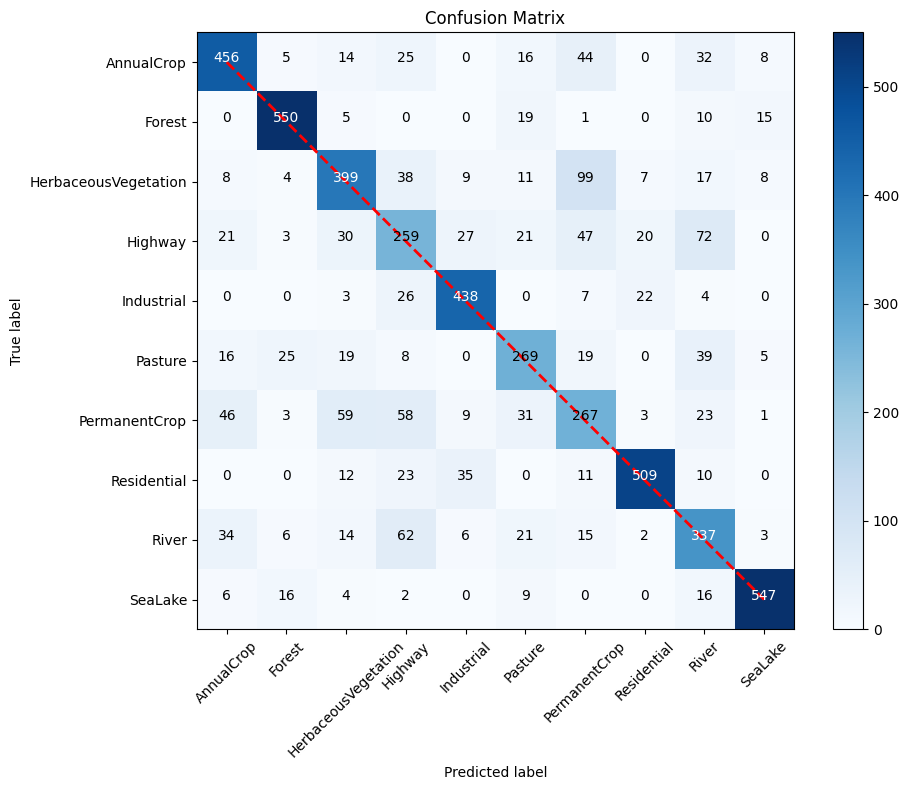

In [19]:
# plot the confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    # make a mark to the diagonal
    plt.plot([0, cm.shape[1]-1], [0, cm.shape[0]-1], color='red', linestyle='--', linewidth=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plot_confusion_matrix(cm, class_names)

In [20]:
# save the model
model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch.pth'
torch.save(bayesian_model.state_dict(), model_path)

# save the guide
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide.pth'
torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch.pkl'
pyro.get_param_store().save(pyro_param_store_path)

Feature TODO:
1. Record loss after each epoch
2. Send result to GPU